Pixeltests School Data Science

*Unit 2, Sprint 2, Module 3*

---
<p style="padding: 10px; border: 2px solid red;">
    <b>Before you start:</b> Today is the day you should submit the dataset for your Unit 2 Build Week project. You can review the guidelines and make your submission in the Build Week course for your cohort on Canvas.</p>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/pixeltests/datasets/main/' #You might not need this, use the data from Kaggle directly!
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Hyperparameter Tuning

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

- **Task 0:** Enter the [Kaggle](https://www.kaggle.com/t/6169ee7701164d24943c98eda2de9b5e) competition using exactly this link!
The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Establish the baseline accuracy score for your dataset.
- **Task 4:** Build `clf_dt`.
- **Task 5:** Build `clf_rf`.
- **Task 6:** Evaluate classifiers using k-fold cross-validation.
- **Task 7:** Tune hyperparameters for best performing classifier.
- **Task 8:** Print out best score and params for model.
- **Task 9:** Create `submission.csv` and upload to Kaggle.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [3]:
import pandas as pd
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [4]:
# File paths
train_features_path = '/content/drive/MyDrive/Pixeltest/predict-faulty-tanzania-water-pumps/train_features.csv'
train_labels_path = '/content/drive/MyDrive/Pixeltest/predict-faulty-tanzania-water-pumps/train_labels.csv'
test_features_path = '/content/drive/MyDrive/Pixeltest/predict-faulty-tanzania-water-pumps/test_features.csv'

# Use the wrangle function to load data
df_train = pd.read_csv(train_features_path)
df_lables = pd.read_csv(train_labels_path)
X_test = pd.read_csv(test_features_path)

print(df_train.shape)
print(df_lables.shape)
print(X_test.shape)
print(df_lables.head())

(47520, 40)
(47520, 1)
(11880, 40)
              status_group
0  functional needs repair
1               functional
2               functional
3           non functional
4               functional


In [17]:
df_train.isnull().sum()

,0
id,0
amount_tsh,0
date_recorded,0
funder,2930
gps_height,0
installer,2940
longitude,0
latitude,0
wpt_name,1
num_private,0


# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [5]:
X = df_train
y = df_lables

# III. Establish Baseline

**Task 3:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [6]:
baseline_acc = y['status_group'].value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5430765993265994


# IV. Build Models

**Task 4:** Build a `Pipeline` named `clf_dt`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` Predictor.

**Note:** Do not train `clf_dt`. You'll do that in a subsequent task.

In [7]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline


clf_dt = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
)

**Task 5:** Build a `Pipeline` named `clf_rf`. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Do not train `clf_rf`. You'll do that in a subsequent task.

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42)
)

# V. Check Metrics

**Task 6:** Evaluate the performance of both of your classifiers using k-fold cross-validation.

In [9]:
from sklearn.model_selection import cross_val_score

cv_scores_dt = cross_val_score(clf_dt, X, y, cv=5, scoring='accuracy')

cv_scores_rf = cross_val_score(clf_rf, X, y, cv=5, scoring='accuracy')


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

In [10]:
print('CV scores DecisionTreeClassifier')
print(cv_scores_dt)
print('Mean CV accuracy score:', cv_scores_dt.mean())
print('STD CV accuracy score:', cv_scores_dt.std())

CV scores DecisionTreeClassifier
[0.70286195 0.6930766  0.69581229 0.6947601  0.68855219]
Mean CV accuracy score: 0.6950126262626263
STD CV accuracy score: 0.004643287933487525


In [11]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())  # Best performing model

CV score RandomForestClassifier
[0.79997896 0.8052399  0.80787037 0.80281987 0.80397727]
Mean CV accuracy score: 0.8039772727272727
STD CV accuracy score: 0.002610615293956488


# VI. Tune Model

**Task 7:** Choose the best performing of your two models and tune its hyperparameters using a `RandomizedSearchCV` named `model`. Make sure that you include cross-validation and that `n_iter` is set to at least `25`.

**Note:** If you're not sure which hyperparameters to tune, check the notes from today's guided project and the `sklearn` documentation.

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def standardScaler():
  return StandardScaler()


pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    standardScaler(),
    RandomForestClassifier(random_state=42)
)


param_dist = {
    'randomforestclassifier__bootstrap' : [True, False],
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth' : [2,5,6,8,10, None],
    'randomforestclassifier__min_samples_leaf' : [1, 2, 4],
    'randomforestclassifier__min_samples_split' : [2, 5, 10],
    'randomforestclassifier__n_estimators': [100, 500],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']

}


model = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

model.fit(X, y)


print("Best CV Accuracy:", model.best_score_)
print("Best Parameters:", model.best_params_)



Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

Best CV Accuracy: 0.763594276094276
Best Parameters: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__bootstrap': True}


**Task 8:** Print out the best score and best params for `model`.

In [13]:
best_score = model.best_score_
best_params =  model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.763594276094276
Best params for `model`: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__bootstrap': True}


In [14]:
# Using XGBOOST on same dataset

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
# Import accuracy_score
from sklearn.metrics import accuracy_score

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_encoded = label_encoder.fit_transform(y['status_group'])


clf_xgb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(
    n_estimators=300,
    learning_rate=0.06,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
)


# Use the encoded target variable for training
clf_xgb.fit(X, y_encoded)

y_pred_xg_train = clf_xgb.predict(X)
print(y_pred_xg_train)

accuracy_xg = accuracy_score(y_encoded, y_pred_xg_train)
print("Accuracy:", accuracy_xg)

y_pred_xg = clf_xgb.predict(X_test)
print(y_pred_xg)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:55:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1 0 0 ... 0 1 0]
Accuracy: 0.8092382154882155
[0 0 0 ... 2 0 0]


# Communicate Results

**Task 9:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site.

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting.

In [15]:

y_pred_test = model.predict(X_test)
print(y_pred_test.shape)

# Create submission DataFrame with S.No. starting from 1
submission = pd.DataFrame({
    'S.No.': range(1, len(y_pred_xg) + 1),
    'status_group': y_pred_xg
})

submission.to_csv('submission_xg.csv')

(11880,)


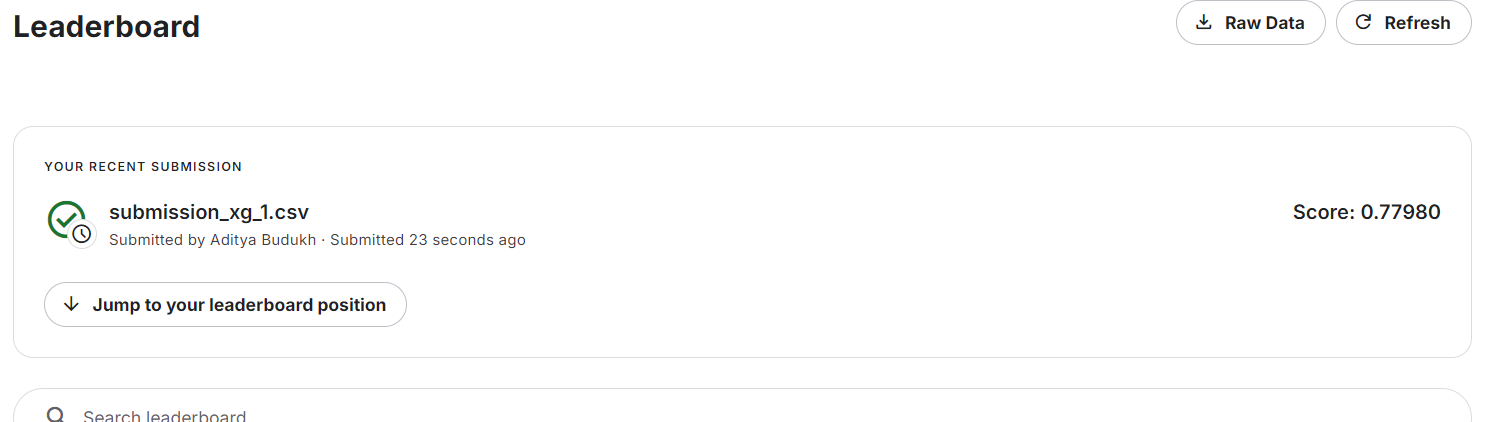